### Case Study

Many strategies can be highly profitable depending on whether you are in an upward trending, downward trending or oscillating market. However, how can you tell what market you are in and in addition do this without an subjective bias?

Hidden Markov Models allow us to determine any number of states we like, given inputs such as returns and volatility (or any inputs of your choosing), to help ascertain what state - or regime - the market is in. This is part of a type of analysis known as Regime identification.

### Imports

In [1]:

import pandas as pd
import numpy as np

from pyhhmm.gaussian import GaussianHMM


import matplotlib.pyplot as plt
import fix_yahoo_finance
import yfinance

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



### Data Management

In [33]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2022-06-1"
#symbol = "SPY"
#[OLECTRA,"LT","CONCOR","ELGIEQUIP","IOC","BEL","TATAELXSI","^NSEI"]
stock_name = "CONCOR.NS"

data = yfinance.download(tickers = stock_name,start="2010-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)



data = data[["Open", "High", "Low", "Close","Volume"]]


[*********************100%***********************]  1 of 1 completed


In [25]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Returns,Range
Date,,,,,,,
2010-03-09,209.974248,211.471620,208.253149,209.036255,244504,-0.001603,0.015455
2010-03-10,209.216961,212.538690,208.459683,211.755585,108464,0.013009,0.019567
2010-03-11,212.555923,214.793340,208.253164,210.765961,320985,-0.004673,0.031405
2010-03-12,209.457897,212.452592,209.457897,211.359711,656254,0.002817,0.014297
2010-03-15,211.178993,213.227101,208.950169,211.893234,435093,0.002524,0.020469


In [26]:
# Structure Data
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
inf_mask = np.isinf(df)

# Filter the Series to exclude Inf values
df = df[~inf_mask]

X_train = df[["Returns", "Range"]]
X_train.tail()

,Returns,Range
Date,,
2023-07-03,-0.007177,0.033570
2023-07-04,0.011643,0.016316
2023-07-05,0.012562,0.025061
2023-07-06,0.025184,0.030626
2023-07-07,0.000000,0.000000


### HMM Learning

In [34]:
# Train Model
model = GaussianHMM(n_states=3, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(<pyhhmm.gaussian.GaussianHMM at 0x7fe9e181b1c0>, 18228.297690499145)

In [35]:
# Check Results
hidden_states = model.predict([X_train.values])[0]
print(hidden_states[:40])
len(hidden_states)

[0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 1 2 2 1 0 0 1 1 0 0 2
 1 0 0]


3293

In [36]:
# Regime state means for each feature
model.means

array([[ 8.54423914e-05,  2.57018391e-02],
       [-1.62051190e-02,  5.09841177e-02],
       [ 2.87596138e-02,  6.13531902e-02]])

In [37]:
# Regime state covars for each feature
model.covars

array([[[ 1.40475532e-04, -1.66542947e-06],
        [-1.66542947e-06,  7.76640510e-05]],

       [[ 5.56885999e-04, -2.33836064e-04],
        [-2.33836064e-04,  5.21161792e-04]],

       [[ 6.87985985e-04,  4.59153729e-04],
        [ 4.59153729e-04,  1.05549934e-03]]])

### Data Visualization

In [38]:
# Structure the prices for plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df["Close"].values.astype(float)
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
#     if s == 3:
#         labels_0.append(float('nan'))
#         labels_1.append(float('nan'))
#         labels_2.append(float('nan'))
#         labels_3.append(prices[i])
    i += 1

Correct number of rows:  True


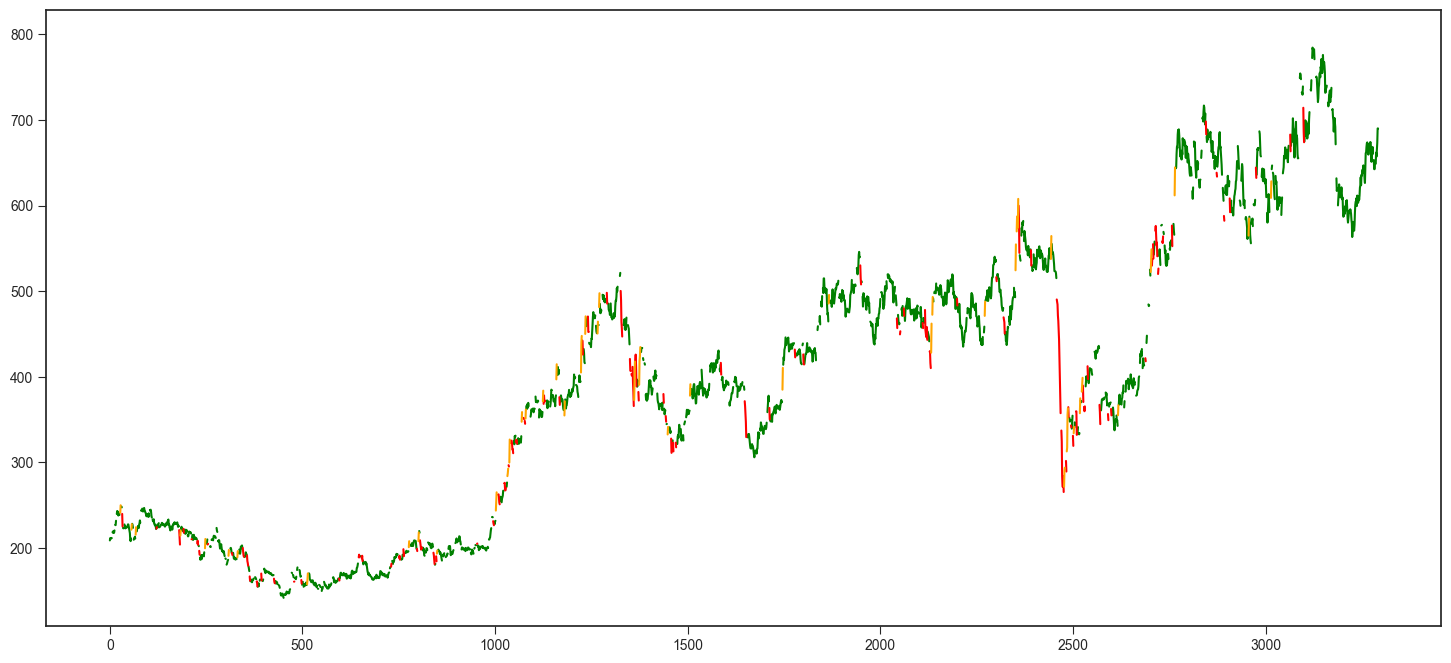

In [39]:
# Plot Chart
fig = plt.figure(figsize= (18, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="red")
plt.plot(labels_2, color="orange")
plt.plot(labels_3, color="black")
plt.show()

### Conclusion

Although work is still yet to be done in the following notebook, we can cleary see from the chart above, that the Hidden Markov Model has been able to identify market regimes based on returns and volatility behaviour.

### Useful Resources

HMM Colab Version with Backtest: https://colab.research.google.com/drive/12qzR8SrhfhQDBImKYQqUKdj6n60E9jNp?usp=sharing